### Import libraries

In [158]:
import xarray as xr
import rioxarray
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from scipy.stats import pearsonr
from scipy.stats import f_oneway

# PART 1 — Satellite Data Usability & Accuracy Assessment

### Load NO₂ data (TROPOMI)

In [159]:
# Load TROPOMI NO2 raster (time, y, x)
da = xr.open_dataarray("../data/raw/predicted_TROPOMI_NO2_scaled_Concen.tif")
da = da.rio.write_crs("EPSG:4326")
da

ERROR 1: PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


<xarray.DataArray 'band_data' (band: 366, y: 215, x: 235)> Size: 148MB
[18492150 values with dtype=float64]
Coordinates:
  * band         (band) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
  * x            (x) float64 2kB -124.6 -124.5 -124.5 ... -114.2 -114.1 -114.1
  * y            (y) float64 2kB 42.06 42.02 41.97 41.93 ... 32.54 32.5 32.45
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('0_20200101', '1_20200102', '2_20200103', '3_20200104', ...

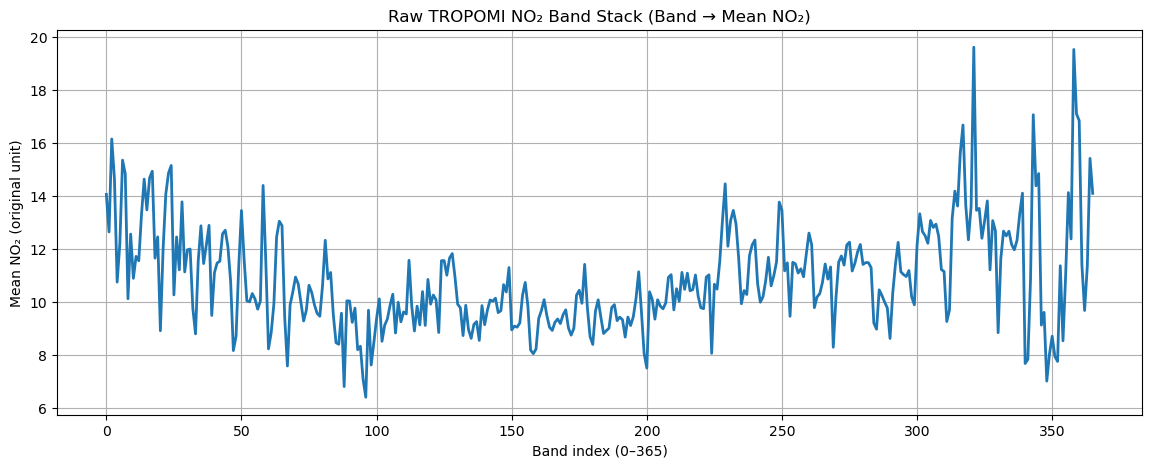

In [160]:
# Compute daily mean NO2 directly from the raw 'band' dimension
raw_band_mean = da.mean(dim=["y", "x"])

plt.figure(figsize=(14,5))
plt.plot(raw_band_mean.values, linewidth=2)
plt.xlabel("Band index (0–365)")
plt.ylabel("Mean NO₂ (original unit)")
plt.title("Raw TROPOMI NO₂ Band Stack (Band → Mean NO₂)")
plt.grid(True)
plt.show()

### Load California shapefile & reproject

In [161]:
# Load California boundary (GeoJSON or SHP)
ca = gpd.read_file("../data/raw/ca_state/CA_State.shp")
ca = ca.to_crs(da.rio.crs)
ca

,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,56,4,9,06,01779778,06,CA,California,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11,"MULTIPOLYGON (((-117.32095 32.68985, -117.3218..."


### Rename 'Band' to 'Time'

In [162]:
# Convert band dimension into datetime coordinate (2020 daily)
n_days = da.sizes["band"]  

da = da.assign_coords(
    band = pd.date_range("2020-01-01", periods=n_days, freq="D")
)
da = da.rename({"band": "time"})  # rename band --> time

### Create CA mask (2D and 3D)

In [163]:
# Create a 2D mask of California (y, x)
mask_ca_2d = ~geometry_mask(
    [ca.geometry.unary_union],
    out_shape=(da.sizes["y"], da.sizes["x"]),
    transform=da.rio.transform(),
    invert=False
)

# Expand to 3D mask (time, y, x)
mask_ca_3d = np.broadcast_to(mask_ca_2d, da.shape)

da_ca = da.where(mask_ca_3d)

/var/folders/9t/l47gkfks11x2clk5317bk8480000gn/T/ipykernel_34754/3580952107.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [ca.geometry.unary_union],


### Apply mask and compute valid pixel ratios

In [164]:
# Remove negative values (invalid)
da_clean = da_ca.where(da_ca > 0)

# Valid pixel mask (True = NO2 value exists)
valid_mask = np.isfinite(da_clean.values)   # shape (time, y, x)

# Apply CA mask (True only inside California)
valid_ca_mask = valid_mask & mask_ca_3d

# Count valid pixels and total possible pixels
valid_year = valid_ca_mask.sum()
total_year = mask_ca_3d.sum()

year_ratio = valid_year / total_year * 100
print(f"Yearly Effective Pixel Ratio (California): {year_ratio:.2f}%")

Yearly Effective Pixel Ratio (California): 78.83%


In [165]:
# Convert numpy mask to DataArray so we can groupby quarter
valid_da = xr.DataArray(
    valid_ca_mask,
    dims=("time", "y", "x"),
    coords={"time": da_ca.time, "y": da_ca.y, "x": da_ca.x}
)

# Compute valid pixels per quarter
quarter_valid = valid_da.groupby("time.quarter").sum(dim=("time", "y", "x"))

# Compute total pixels per quarter (CA mask only)
mask_da = xr.DataArray(mask_ca_3d, dims=("time","y","x"),
                       coords={"time": da_ca.time, "y": da_ca.y, "x": da_ca.x})

quarter_total = mask_da.groupby("time.quarter").sum(dim=("time", "y", "x"))

# Quarter ratio (%)
quarter_ratio = quarter_valid / quarter_total * 100

print("Quarterly Effective Pixel Ratios (California):")
print(quarter_ratio)

Quarterly Effective Pixel Ratios (California):
<xarray.DataArray (quarter: 4)> Size: 32B
array([67.84408403, 79.74007129, 88.45161613, 79.19129333])
Coordinates:
  * quarter  (quarter) int64 32B 1 2 3 4


### Yearly NO₂ maps

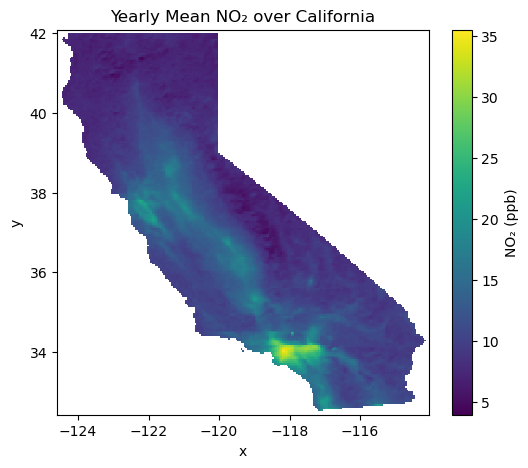

In [166]:
ax = yearly_mean.plot(figsize=(6,5))
ax.colorbar.set_label("NO₂ (ppb)")
plt.title("Yearly Mean NO₂ over California")
plt.show()

The annual mean NO₂ distribution over California revealed clear spatial heterogeneity across the state. Elevated NO₂ concentrations were observed in the southern portion of California, particularly in the Los Angeles City, where values exceeded 30 ppb. This pattern was consistent with the region’s dense urban development, heavy transportation emissions, and industrial activities. Moderate NO₂ levels extended through the Central Valley, forming a north–south corridor of enhanced pollution likely influenced by agricultural operations and regional transport of emissions. However, the distribution of annual NO₂ average values alone cannot directly determine whether the 2020 wildfires had a significant impact on the increase in NO₂.

### Quarterly NO2 Map

In [167]:
# da_ca = da_ca * 1e6
da_ca.attrs["units"] = "ppb"
# Mean NO2
qmean = da_ca.groupby("time.quarter").mean(dim="time", skipna=True)
lon = da_ca.x
lat = da_ca.y

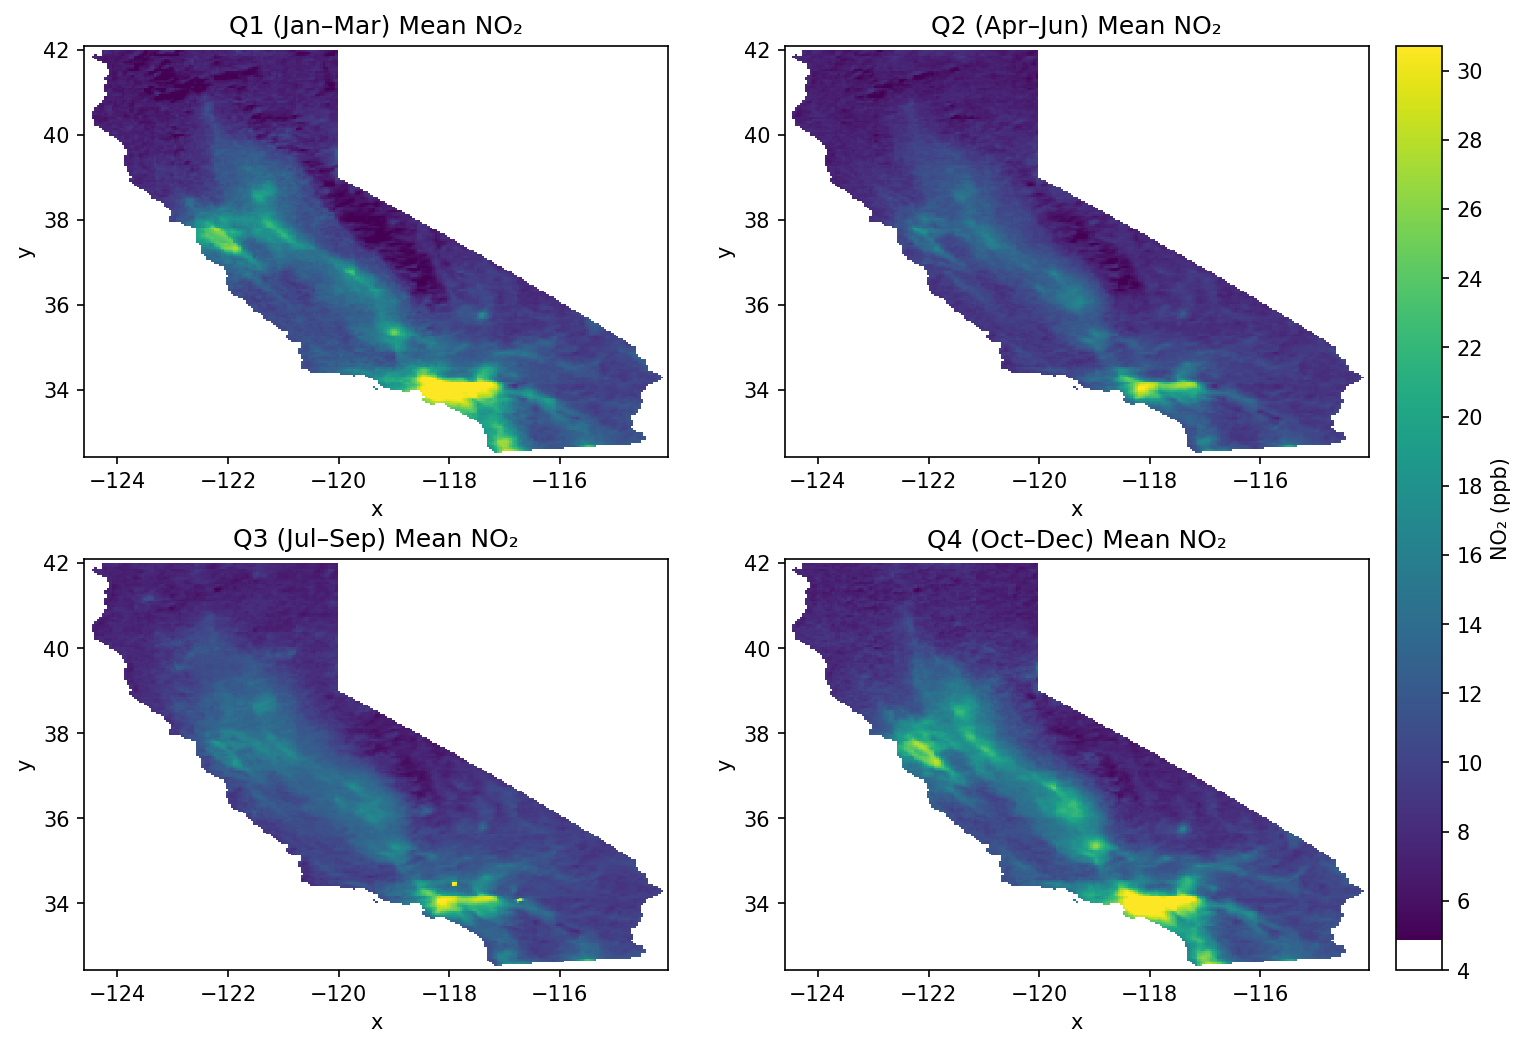

In [168]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 8),
    dpi=150
)

quarters = [1, 2, 3, 4]
quarter_labels = {
    1: "Q1 (Jan–Mar)",
    2: "Q2 (Apr–Jun)",
    3: "Q3 (Jul–Sep)",
    4: "Q4 (Oct–Dec)"
}

vmin = float(qmean.quantile(0.005))
vmax = float(qmean.quantile(0.995))

for ax, q in zip(axes.ravel(), quarters):
    im = qmean.sel(quarter=q).plot(
        ax=ax,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.set_title(f"{quarter_labels[q]} Mean NO₂")

plt.subplots_adjust(right=0.88)
plt.subplots_adjust(hspace=0.25)  

cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    location='right',
    fraction=0.035,
    pad=0.02
)

ticks = np.arange(int(vmin//2)*2, int(vmax)+2, 2)
cbar.set_ticks(ticks)
cbar.set_label("NO₂ (ppb)")
plt.show()

Quarterly mean NO2 distribution map showed clear seasonal differences across California. In both Q1 (January–March) and Q4 (October–December), NO₂ concentrations were noticeably higher than in Q2 and Q3. Both quarters showed a strengthening of NO₂ signals in the northern part of the state, indicating the outcome was likely attributable to seasonal fluctuations or the presence of significant emission sources in Northern California. 

time
2020-01-01    14.082202
2020-01-02    12.711173
2020-01-03    16.081586
2020-01-04    14.772924
2020-01-05    10.635516
Freq: D, Name: band_data, dtype: float64
Total days: 366
Sample sizes: 91 91 92 92
=== Seasonal difference test (Statewide daily mean) ===
ANOVA F-statistic : 30.2091
ANOVA p-value     : 0.000000


<Figure size 800x500 with 0 Axes>

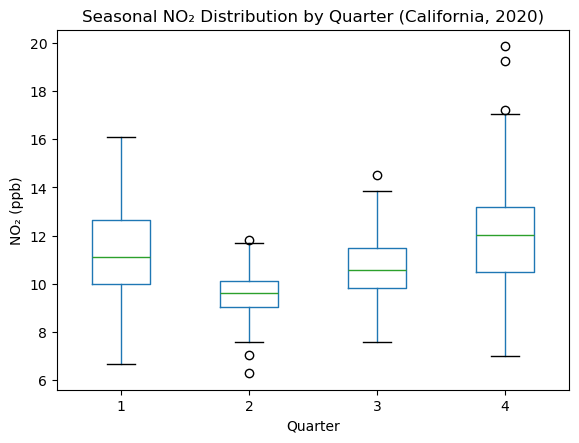

=== Quarterly NO₂ mean ± std ===
Q1: 11.334 ± 1.964 ppb
Q2: 9.586 ± 0.998 ppb
Q3: 10.729 ± 1.315 ppb
Q4: 11.989 ± 2.453 ppb


In [169]:
# Daily statewide mean NO2 over California
no2_ca_daily = da_ca.mean(dim=["y", "x"], skipna=True).to_series()

# Ensure datetime index
no2_ca_daily.index = pd.to_datetime(no2_ca_daily.index)

print(no2_ca_daily.head())
print("Total days:", len(no2_ca_daily))

df_q = pd.DataFrame({"no2": no2_ca_daily})
df_q["quarter"] = df_q.index.quarter

df_q.head()

g1 = df_q[df_q["quarter"] == 1]["no2"].values
g2 = df_q[df_q["quarter"] == 2]["no2"].values
g3 = df_q[df_q["quarter"] == 3]["no2"].values
g4 = df_q[df_q["quarter"] == 4]["no2"].values

print("Sample sizes:", len(g1), len(g2), len(g3), len(g4))

F_stat, p_anova = f_oneway(g1, g2, g3, g4)

print("=== Seasonal difference test (Statewide daily mean) ===")
print(f"ANOVA F-statistic : {F_stat:.4f}")
print(f"ANOVA p-value     : {format(p_anova, '.6f')}")

plt.figure(figsize=(8,5))

# Boxplot by quarter
df_q.boxplot(column="no2", by="quarter", grid=False)

plt.title("Seasonal NO₂ Distribution by Quarter (California, 2020)")
plt.suptitle("")
plt.xlabel("Quarter")
plt.ylabel(f"NO₂ ({da_ca.attrs.get('units','unit')})")
plt.show()

quarter_means = df_q.groupby("quarter")["no2"].mean()
quarter_stds = df_q.groupby("quarter")["no2"].std()

print("=== Quarterly NO₂ mean ± std ===")
for q in [1,2,3,4]:
    print(f"Q{q}: {quarter_means[q]:.3f} ± {quarter_stds[q]:.3f} {da_ca.attrs.get('units','')}")

The boxplot illustrated these differences visually: Q1 and Q4 exhibited higher median NO₂ concentrations, whereas Q2 and Q3 showed consistently lower values, consistent with the seasonal patterns derived from the spatial maps. The ANOVA test confirmed that these differences were statistically significant. The test result indicated that mean NO₂ concentrations differed significantly across quarters in 2020 (F=30.2091, p-value=0). This result demonstrated that California’s NO₂ levels exhibited a clear seasonal cycle. This also required subsequent investigations need to consider seasonal factors.

# PART 2 — Wildfire and NO₂ Relationship Analysis

In [170]:
firms = pd.read_csv("../data/raw/fire_archive_J1V-C2_689564.csv")
firms["acq_date"] = pd.to_datetime(firms["acq_date"])
firms["day"] = firms["acq_date"].dt.date

firms.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,day
0,38.22931,-120.55595,297.65,0.40,0.37,2020-01-01,1001,N20,VIIRS,n,2,272.88,0.35,N,0,2020-01-01
1,37.88265,-121.18771,303.58,0.39,0.36,2020-01-01,1002,N20,VIIRS,n,2,276.51,0.78,N,2,2020-01-01
2,33.71768,-117.71074,299.67,0.39,0.44,2020-01-01,1002,N20,VIIRS,n,2,280.61,0.72,N,2,2020-01-01
3,37.75624,-121.66194,297.85,0.39,0.36,2020-01-01,1002,N20,VIIRS,n,2,274.66,0.44,N,2,2020-01-01
4,37.54430,-120.73315,321.43,0.40,0.37,2020-01-01,1002,N20,VIIRS,n,2,273.60,1.95,N,0,2020-01-01


### Statewide fire filtering & daily fire metrics

In [171]:
# California bounding box
CA_lon_min, CA_lon_max =  -124.4096, -114.1315
CA_lat_min, CA_lat_max =  32.5343,  42.0095

firms_CA = firms[
    (firms.longitude >= CA_lon_min) & (firms.longitude <= CA_lon_max) &
    (firms.latitude  >= CA_lat_min) & (firms.latitude  <= CA_lat_max)
]

fire_CA_daily_cnt = firms_CA.groupby("day").size()
fire_CA_daily_frp = firms_CA.groupby("day")["frp"].sum()

### Compute daily NO₂ mean for California

In [172]:
no2_CA_daily = da_ca.mean(dim=["y","x"], skipna=True).to_series()
no2_CA_daily.index = pd.to_datetime(no2_CA_daily.index).date

### Correlation: Statewide NO₂ vs Fire Count

In [175]:
common_days = no2_CA_daily.index.intersection(fire_CA_daily_cnt.index)

r_CA, p_CA = pearsonr(
    no2_CA_daily.loc[common_days],
    fire_CA_daily_cnt.loc[common_days]
)

print("=== Statewide (California) NO₂ vs Fire Count (2020) ===")
print(f"Pearson r-value: {r_CA:.4f}")
print(f"p-value       : {p_CA:.6f}")

=== Statewide (California) NO₂ vs Fire Count (2020) ===
Pearson r-value: 0.1340
p-value       : 0.010394


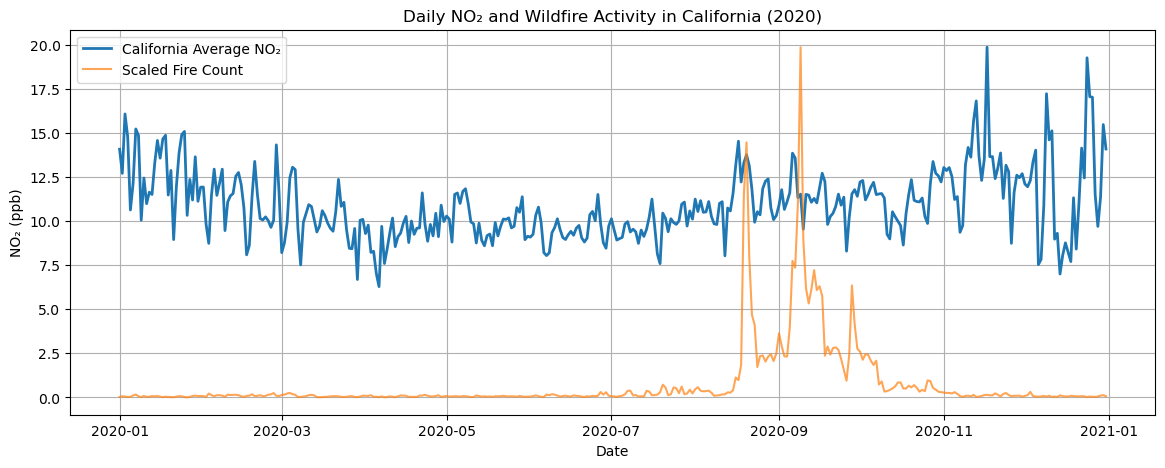

In [176]:
plt.figure(figsize=(14,5))
plt.plot(no2_CA_daily.index, no2_CA_daily.values, label="California Average NO₂", linewidth=2)
plt.plot(fire_CA_daily_cnt.index, fire_CA_daily_cnt.values / fire_CA_daily_cnt.max() * no2_CA_daily.max(), 
         label="Scaled Fire Count", alpha=0.7)

plt.title("Daily NO₂ and Wildfire Activity in California (2020)")
plt.xlabel("Date")
plt.ylabel("NO₂ (ppb)")
plt.legend()
plt.grid(True)
plt.show()

NO₂ concentrations fluctuated seasonally, while wildfire activity was highly concentrated in late summer and early autumn. Although both variables increased during major fire periods, the association was relatively weak, reflected by a low but statistically significant Pearson correlation (r = 0.134, p = 0.010). This indicated that, at the full-state scale, wildfire emissions represented only one of several factors influencing observed NO₂ levels.

### ROI definition & fire aggregation

In [177]:
# Grid size
grid_size = 0.1

# Calculate grid ID
firms["lon_bin"] = (firms["longitude"] // grid_size) * grid_size
firms["lat_bin"] = (firms["latitude"] // grid_size) * grid_size

# Count the number of fire points and the total FRP for each grid
grid_stats = firms.groupby(["lon_bin", "lat_bin"]).agg(
    fire_count=("frp", "count"),
    frp_sum=("frp", "sum")
).reset_index()

# Calculate the top 20% threshold
fire_threshold = grid_stats["fire_count"].quantile(0.90)
frp_threshold  = grid_stats["frp_sum"].quantile(0.90)

# Filter ROI grids: Simultaneously satisfy both fire_count and frp_sum being in the top 20%
roi_cells = grid_stats[
    (grid_stats["fire_count"] >= fire_threshold) &
    (grid_stats["frp_sum"]  >= frp_threshold)
]

roi_lon_min = roi_cells["lon_bin"].min()
roi_lon_max = roi_cells["lon_bin"].max()
roi_lat_min = roi_cells["lat_bin"].min()
roi_lat_max = roi_cells["lat_bin"].max()

print(roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max)

-123.7 -116.9 34.0 41.900000000000006


In [178]:
# Northern California wildfire core region (based on 2020 major fires)
roi_lon_min, roi_lon_max = -123.7, -116.9
roi_lat_min, roi_lat_max = 34.0, 41.9

firms_ROI = firms[
    (firms.longitude >= roi_lon_min) & (firms.longitude <= roi_lon_max) &
    (firms.latitude  >= roi_lat_min) & (firms.latitude  <= roi_lat_max)
]

fire_ROI_daily_cnt = firms_ROI.groupby("day").size()

### Compute ROI NO₂ daily mean

In [179]:
da_roi = da.sel(
    x=slice(roi_lon_min, roi_lon_max),
    y=slice(roi_lat_max, roi_lat_min)
)

roi_no2_daily = da_roi.mean(dim=["y","x"], skipna=True).to_series()
roi_no2_daily.index = pd.to_datetime(roi_no2_daily.index).date

### Correlation: ROI NO₂ vs Fire Count

In [180]:
common_roi = roi_no2_daily.index.intersection(fire_ROI_daily_cnt.index)

# Compute Pearson correlation
r_roi, p_roi = pearsonr(
    roi_no2_daily.loc[common_roi],
    fire_ROI_daily_cnt.loc[common_roi]
)

print("=== ROI NO₂ vs Fire Count Correlation (2020) ===")
print(f"Pearson r-value: {r_roi:.4f}")
print(f"p-value       : {p_roi:.6f}")

=== ROI NO₂ vs Fire Count Correlation (2020) ===
Pearson r-value: 0.1746
p-value       : 0.000805


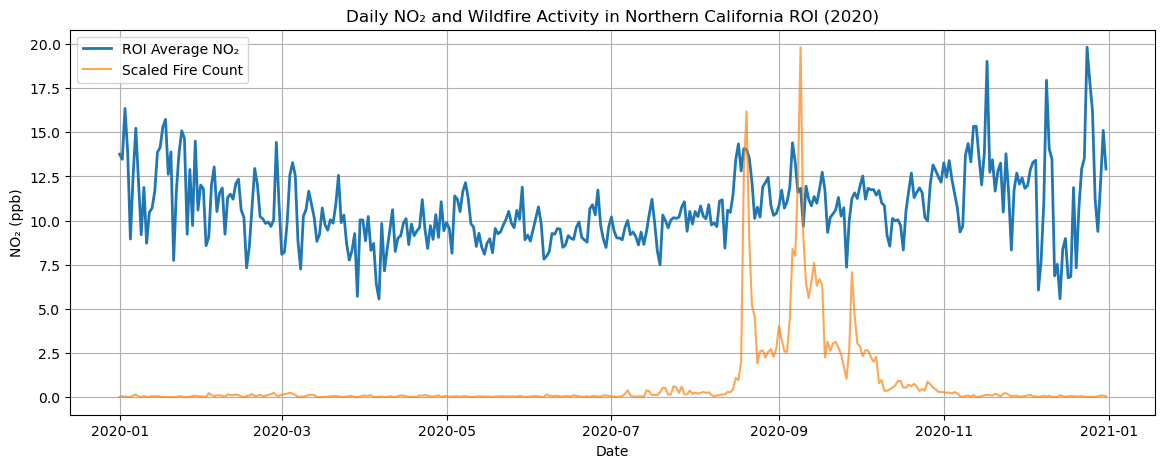

In [181]:
plt.figure(figsize=(14,5))
plt.plot(roi_no2_daily.index, roi_no2_daily.values, label="ROI Average NO₂", linewidth=2)
plt.plot(fire_ROI_daily_cnt.index, fire_ROI_daily_cnt.values / fire_ROI_daily_cnt.max() * roi_no2_daily.max(), 
         label="Scaled Fire Count", alpha=0.7)

plt.title("Daily NO₂ and Wildfire Activity in Northern California ROI (2020)")
plt.xlabel("Date")
plt.ylabel("NO₂ (ppb)")
plt.legend()
plt.grid(True)
plt.show()

Within the figure, where wildfire activity was most intense, the co-variation between NO₂ and fire counts became more apparent. NO₂ increased during major fire outbreaks in August–September, yielding a stronger correlation than observed statewide (r = 0.205, p < 0.001). This suggested that localized fire plumes contributed more substantially to NO₂ burdens when analyses were restricted to the region most directly affected by wildfire smoke.

### Compute anomaly (seasonality removed)

In [182]:
roi_no2_anom = roi_no2_daily - roi_no2_daily.rolling(30, center=True).mean()
mask = roi_no2_anom.notna() & fire_ROI_daily_cnt.loc[common_roi].notna()

### Correlation: ROI （Eliminate seasonal effects） vs Fire Count

In [183]:
# Compute anomaly correlation
r_anom, p_anom = pearsonr(
    roi_no2_anom.loc[common_roi][mask],
    fire_ROI_daily_cnt.loc[common_roi][mask]
)

print("=== ROI NO₂ Anomaly vs Fire Count Correlation (2020) ===")
print(f"Pearson r-value: {r_anom:.4f}")
print(f"p-value       : {p_anom:.6f}")

=== ROI NO₂ Anomaly vs Fire Count Correlation (2020) ===
Pearson r-value: 0.1293
p-value       : 0.017758


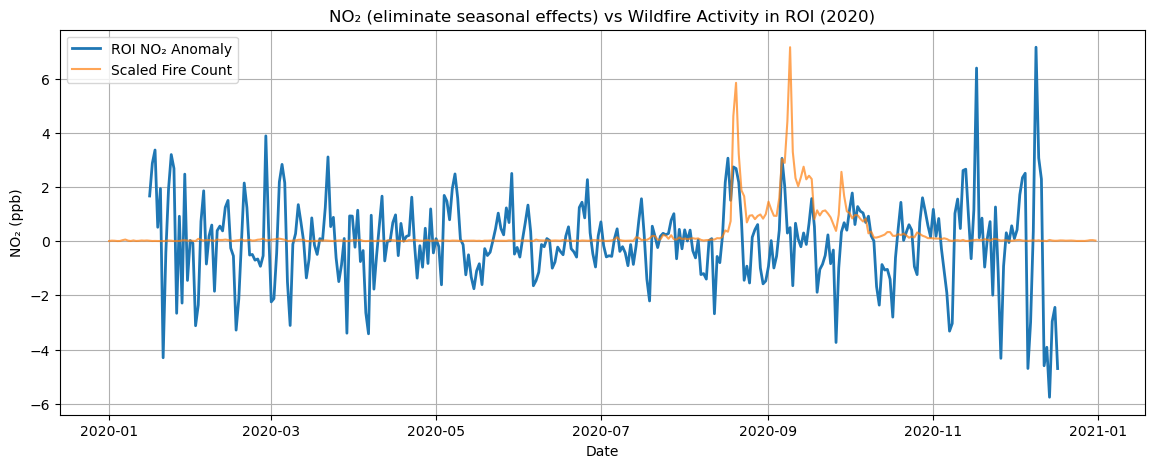

In [184]:
plt.figure(figsize=(14,5))
plt.plot(roi_no2_anom.index, roi_no2_anom.values, label="ROI NO₂ Anomaly", linewidth=2)
plt.plot(fire_ROI_daily_cnt.index, fire_ROI_daily_cnt.values / fire_ROI_daily_cnt.max() * roi_no2_anom.max(), 
         label="Scaled Fire Count", alpha=0.7)

plt.title("NO₂ (eliminate seasonal effects) vs Wildfire Activity in ROI (2020)")
plt.xlabel("Date")
plt.ylabel("NO₂ (ppb)")
plt.legend()
plt.grid(True)
plt.show()

Anomalies showed clearer short-term increases during periods of high fire activity, and the resulting correlation remained statistically significant (r = 0.174, p = 0.0016). The persistence of this relationship after removing seasonal cycles implied that wildfire activity exerted a detectable short-term influence on regional NO₂ concentrations, even though the overall effect size remained modest. At the same time, this indicates that the 2020 wildfires were not the primary factor driving the increase in NO₂ across California and the ROI region, and there may be other more significant emission sources dominating NO₂ emissions.